In [49]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
import os
from langgraph.checkpoint.memory import InMemorySaver
import time

In [50]:
class MyState(TypedDict):
    a : float
    b : float
    multiply: float
    add: float

In [51]:
def multiply(state : MyState) -> float:
    print("Starting Multiplication step with inputs:", state['a'], state['b'])
    time.sleep(10)  # Simulate a delay for debugging purposes

    print("Multiplication step executed with result:", state['a'] * state['b'])
    
    return {'multiply': state['a'] * state['b']}

def add(state: MyState) -> float:
    add = state['a'] + state['b']
    print("Addition step executed with result:", add)
    return {'add': add}

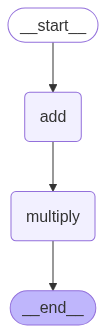

In [52]:
graph = StateGraph(MyState)

graph.add_node('multiply', multiply)
graph.add_node('add', add)

graph.add_edge(START, 'add')
graph.add_edge('add', 'multiply')
graph.add_edge('multiply', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

workflow


In [53]:
config1 = {"configurable" : {'thread_id' : 1}}
initial_state = MyState(a=2, b=3)
workflow.invoke(initial_state, config=config1)

Addition step executed with result: 5
Starting Multiplication step with inputs: 2 3


KeyboardInterrupt: 

In [54]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'a': 2, 'b': 3, 'add': 5}, next=('multiply',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073327-c455-636c-8001-df1940e3e5b4'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-07T02:01:51.896245+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073327-c453-65f8-8000-a6f4164b1fad'}}, tasks=(PregelTask(id='bef00393-461d-d58d-cbf5-5633d238f98a', name='multiply', path=('__pregel_pull', 'multiply'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'a': 2, 'b': 3}, next=('add',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073327-c453-65f8-8000-a6f4164b1fad'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-07T02:01:51.895489+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073327-c452-6036-bf

In [55]:
workflow.invoke(None, config=config1)

Starting Multiplication step with inputs: 2 3
Multiplication step executed with result: 6


{'a': 2, 'b': 3, 'multiply': 6, 'add': 5}

In [56]:
list(workflow.get_state_history(config1))


[StateSnapshot(values={'a': 2, 'b': 3, 'multiply': 6, 'add': 5}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073328-9e40-6ef0-8002-74b0d44e835f'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-07T02:02:14.746863+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073327-c455-636c-8001-df1940e3e5b4'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'a': 2, 'b': 3, 'add': 5}, next=('multiply',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073327-c455-636c-8001-df1940e3e5b4'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-07T02:01:51.896245+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073327-c453-65f8-8000-a6f4164b1fad'}}, tasks=(PregelTask(id='bef00393-461d-d58d-cbf5-5633d238f98a', name='multiply', path=('__pregel_pull', 'multiply'), error=

In [58]:
#  time traveling to simulate from a checkpoint
workflow.invoke(None, config = {"configurable" : {'thread_id' : 1, 'checkpoint_id' : '1f073327-c453-65f8-8000-a6f4164b1fad' }})

Addition step executed with result: 5
Starting Multiplication step with inputs: 2 3
Multiplication step executed with result: 6


{'a': 2, 'b': 3, 'multiply': 6, 'add': 5}

In [59]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'a': 2, 'b': 3, 'multiply': 6, 'add': 5}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073329-e781-65a0-8002-506d6aebc7b8'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-07T02:02:49.271398+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073329-8814-6180-8001-1902e8438281'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'a': 2, 'b': 3, 'add': 5}, next=('multiply',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073329-8814-6180-8001-1902e8438281'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-07T02:02:39.265206+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f073327-c453-65f8-8000-a6f4164b1fad'}}, tasks=(PregelTask(id='ae935497-922d-70fa-b243-dba95a238c47', name='multiply', path=('__pregel_pull', 'multiply'), error=

In [62]:
#  updating the state and invoking again
workflow.invoke({'a':5}, config = {"configurable" : {'thread_id' : 1, 'checkpoint_id' : '1f073327-c455-636c-8001-df1940e3e5b4' }})

Addition step executed with result: 8
Starting Multiplication step with inputs: 5 3
Multiplication step executed with result: 15


{'a': 5, 'b': 3, 'multiply': 15, 'add': 8}

In [63]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'a': 5, 'b': 3, 'multiply': 15, 'add': 8}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07332d-7ff8-6fc4-8005-814c4c64ea42'}}, metadata={'source': 'loop', 'step': 5, 'parents': {}}, created_at='2025-08-07T02:04:25.789348+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07332d-2082-6298-8004-b4003be890c2'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'a': 5, 'b': 3, 'add': 8}, next=('multiply',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07332d-2082-6298-8004-b4003be890c2'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-08-07T02:04:15.779281+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07332d-2080-6772-8003-6979d290acbd'}}, tasks=(PregelTask(id='882fecd4-8e2d-3af4-8cd9-a548fe8d3c2f', name='multiply', path=('__pregel_pull', 'multiply'), error